In [6]:
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import datetime as dt
from sklearn.ensemble import RandomForestClassifier 

In [2]:
df = pd.read_csv("./match_data_yearly/all_years.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index(df["Date"])

In [3]:
df

,ID,Year,Sec,Date,Home,Away,HomeID,AwayID,HomeGF,AwayGF,W/L,Stadium,Attendances,HomeRate,AwayRate,HomeRD,AwayRD
Date,,,,,,,,,,,,,,,,,
2006-03-04,6010903,2006,1,2006-03-04,gamba-osaka,urawa-red-diamonds,9,3,1,1,0,万博,20916,1500,1500,0,0
2006-03-05,6012807,2006,1,2006-03-05,ventforet-kofu,shimizu-s-pulse,28,7,0,2,2,小瀬,14277,1500,1500,0,0
2006-03-05,6012231,2006,1,2006-03-05,fc-tokyo,oita-trinita,22,31,2,0,1,味スタ,22531,1500,1500,0,0
2006-03-05,6011323,2006,1,2006-03-05,jubilo-iwata,avispa-fukuoka,13,23,1,1,0,静岡,28564,1500,1500,0,0
2006-03-05,6010820,2006,1,2006-03-05,nagoya-grampus-eight,cerezo-osaka,8,20,3,2,1,瑞穂陸,17199,1500,1500,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,20340120,2020,34,2020-12-19,kashima-antlers,cerezo-osaka,1,20,1,1,0,カシマ,11251,1594,1560,4,-6
2020-12-19,20340810,2020,34,2020-12-19,nagoya-grampus-eight,sanfrecce-hiroshima,8,10,1,0,1,豊田ス,16825,1515,1524,9,-13
2020-12-19,20343331,2020,34,2020-12-19,sagan-tosu,oita-trinita,33,31,2,2,0,駅スタ,8966,1453,1458,17,7


In [44]:
accuracies = []
train_accuracies = []
calibrations = []
error_squares = []

for year in (2013,2014,2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test = df_future[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
    y_test = df_future["W/L"].values


    rf= RandomForestClassifier(max_depth=3, random_state=1234 )  
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    train_accuracies.append(rf.score(X_train,y_train)) 
    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)

    count=0

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    pred_drawrate_sum=0 # 予測引き分け率の和
    actual_draw_sum=0 # 実引き分け数の和

    pred_lossrate_sum=0 # 予測敗率の和
    actual_loss_sum=0 # 実敗北数の和

    for pred in y_pred:
        # ホームが上位予測
        if pred == 1: 
            pred_winrate_sum += y_pred_proba[count][1] 
            pred_drawrate_sum += y_pred_proba[count][0]
            pred_lossrate_sum += y_pred_proba[count][2]

            if y_test[count] == 1: 
                actual_win_sum += 1
            elif y_test[count] == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1

        # アウェイが上位予測
        elif pred==2: 
            pred_winrate_sum += y_pred_proba[count][2] 
            pred_drawrate_sum += y_pred_proba[count][0]
            pred_lossrate_sum += y_pred_proba[count][1]

            if y_test[count] == 2:
                actual_win_sum += 1
            elif y_test[count] == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1

        count+= 1

    calibration = pred_winrate_sum/actual_win_sum
    error_square = ((1-calibration)*100)**2
    error_squares.append(error_square)
    
print(f"的中率の平均値 : {np.mean(accuracies):.3f} / 誤差の2乗の平均値 : {np.mean(error_squares):.3f} (平方根:{math.sqrt(np.mean(error_squares)):.3f})" )


的中率の平均値 : 0.461 / 誤差の2乗の平均値 : 59.615 (平方根:7.721)


# BEGIN

In [17]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeRate","AwayRate"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeRate","AwayRate"]].values
y_test = df_future["W/L"].values


rf= RandomForestClassifier(max_depth=3, random_state=1234)  
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

accuracy = rf.score(X_test,y_test) 

In [18]:
rf.feature_importances_

array([0.44920335, 0.55079665])

<AxesSubplot:>

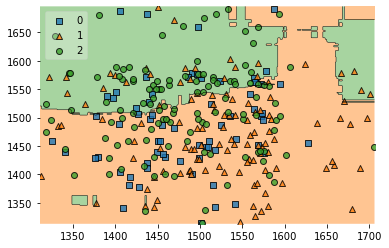

In [19]:
from mlxtend.plotting import plot_decision_regions

plot_decision_regions(X=X_test, y=y_test, clf=rf, legend=2)

<AxesSubplot:>

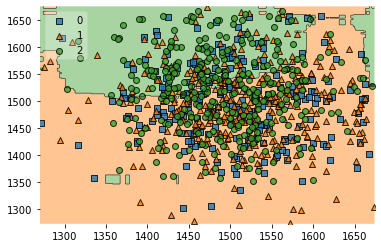

In [20]:
plot_decision_regions(X=X_train, y=y_train, clf=rf, legend=2)

In [21]:
rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.4793028322440087, 0.4738562091503268)

In [26]:
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

1    382
2    322
0    214
dtype: int64
2    120
1    118
0     68
dtype: int64


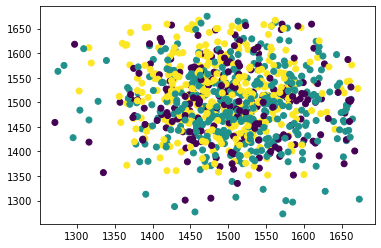

In [27]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

# ---

In [30]:
X_train=df_past[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
y_train = df_past["W/L"].values

from sklearn.manifold import TSNE

tsne = TSNE(random_state=1234)
X_embedded = tsne.fit_transform(X_train)

/home/yokoyama/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yokoyama/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


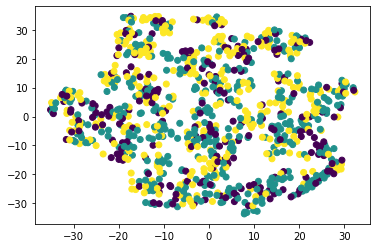

In [31]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train)

# END

### アンダーサンプリングしてみる

In [32]:
from imblearn.under_sampling import RandomUnderSampler 

In [33]:
year = 2020

df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
X_train=df_past[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
y_train = df_past["W/L"].values

df_future = df[f"{year}"]
X_test = df_future[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
y_test = df_future["W/L"].values

In [34]:
rus = RandomUnderSampler(sampling_strategy={1:120, 2:120, 0:60}, random_state=1234)

In [35]:
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [36]:
rf= RandomForestClassifier(max_depth=3, random_state=1234)  
rf.fit(X_train_rus,y_train_rus)
y_pred = rf.predict(X_test)
y_pred_proba=rf.predict_proba(X_test)

In [37]:
accuracy = rf.score(X_test,y_test) 
accuracy

0.46078431372549017

In [39]:
pd.Series(y_pred).value_counts()

1    192
2    114
dtype: int64

In [42]:
accuracies = []
train_accuracies = []
calibrations = []
error_squares = []

for year in (2013,2014,2015,2016,2017,2018,2019,2020):

    df_past = pd.concat([df[f"{year-3}"],df[f"{year-2}"],df[f"{year-1}"]])
    X_train=df_past[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
    y_train = df_past["W/L"].values

    df_future = df[f"{year}"]
    X_test = df_future[["HomeRate","AwayRate","HomeRD","AwayRD"]].values
    y_test = df_future["W/L"].values
    
    rus = RandomUnderSampler(sampling_strategy={1:120, 2:120, 0:60}, random_state=1234)
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
    rf= RandomForestClassifier(max_depth=3, random_state=1234)  
    rf.fit(X_train_rus,y_train_rus)
    y_pred = rf.predict(X_test)
    y_pred_proba=rf.predict_proba(X_test)

    train_accuracies.append(rf.score(X_train,y_train)) 
    accuracy = rf.score(X_test,y_test) 
    accuracies.append(accuracy)

    count=0

    pred_winrate_sum=0 # 予測勝率の和
    actual_win_sum=0 # 実勝利数の和

    pred_drawrate_sum=0 # 予測引き分け率の和
    actual_draw_sum=0 # 実引き分け数の和

    pred_lossrate_sum=0 # 予測敗率の和
    actual_loss_sum=0 # 実敗北数の和

    for pred in y_pred:
        # ホームが上位予測
        if pred == 1: 
            pred_winrate_sum += y_pred_proba[count][1] 
            pred_drawrate_sum += y_pred_proba[count][0]
            pred_lossrate_sum += y_pred_proba[count][2]

            if y_test[count] == 1: 
                actual_win_sum += 1
            elif y_test[count] == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1

        # アウェイが上位予測
        elif pred==2: 
            pred_winrate_sum += y_pred_proba[count][2] 
            pred_drawrate_sum += y_pred_proba[count][0]
            pred_lossrate_sum += y_pred_proba[count][1]

            if y_test[count] == 2:
                actual_win_sum += 1
            elif y_test[count] == 0:
                actual_draw_sum += 1
            else:
                actual_loss_sum += 1

        count+= 1

    calibration = pred_winrate_sum/actual_win_sum
    error_square = ((1-calibration)*100)**2
    error_squares.append(error_square)
    
print(f"的中率の平均値 : {np.mean(accuracies):.3f} / 誤差の2乗の平均値 : {np.mean(error_squares):.3f} (平方根:{math.sqrt(np.mean(error_squares)):.3f})" )


的中率の平均値 : 0.446 / 誤差の2乗の平均値 : 123.672 (平方根:11.121)


### 考察

アンダーサンプリングすることで的中率は全体的に下がる｡ 較正値に関しては大外れしていなく､toto予測の際はアンダーサンプリングで勝敗比を調整すれば､勝ち敗け分けの各確率の予測精度は､調整しないときよりよいかもしれない